In [12]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
import regions
from regions import Regions
from astropy.table import Table

In [3]:
cd ..

/home/savannahgramze/research/lactea-filament/lactea-filament


In [8]:
from jwst_plots import JWSTCatalog

In [2]:
basepath = '/home/savannahgramze/research/Research/JWST/cloudc/'

# Load Catalog

In [10]:
fn_405 = f'{basepath}/images/F410_reproj_merged-fortricolor.fits'
ww = WCS(fits.open(fn_405)[0].header)

In [13]:
cat_fn = f'{basepath}/basic_merged_indivexp_photometry_tables_merged.fits'
basetable = Table.read(cat_fn)

In [14]:
reg_filament = Regions.read(f'./regions_/filament_long.region')
reg_filhole = Regions.read(f'./regions_/filhole.region')
reg_cloudd = Regions.read(f'./regions_/cloudd.region')
reg_cloudc1 = Regions.read(f'./regions_/cloudc1.region')
reg_cloudc2 = Regions.read(f'./regions_/cloudc2.region')
#reg_filament_long = Regions.read(f'{basepath}/regions_/filament_long.region')

In [15]:
base_jwstcatalog = JWSTCatalog(basetable)
mask_qf = base_jwstcatalog.get_qf_mask(0.4)
cat_use = JWSTCatalog(basetable[mask_qf])

In [16]:
cat_filament = JWSTCatalog(cat_use.table_region_mask(reg_filament, wcs=ww))
cat_cloudd =   JWSTCatalog(cat_use.table_region_mask(reg_cloudd, wcs=ww))
cat_cloudc1 =  JWSTCatalog(cat_use.table_region_mask(reg_cloudc1, wcs=ww))
cat_cloudc2 =  JWSTCatalog(cat_use.table_region_mask(reg_cloudc2, wcs=ww))

In [17]:
mask_outside = ~cat_use.get_region_mask(reg_filament, wcs=ww) & ~cat_use.get_region_mask(reg_cloudd, wcs=ww) & ~cat_use.get_region_mask(reg_cloudc1, wcs=ww) & ~cat_use.get_region_mask(reg_cloudc2, wcs=ww)
cat_outside = JWSTCatalog(cat_use.catalog[mask_outside])

In [18]:
mask_filament = cat_use.get_region_mask(reg_filament, wcs=ww) & ~cat_use.get_region_mask(reg_filhole, wcs=ww)
cat_only_filament = JWSTCatalog(cat_use.catalog[mask_filament])

# Bin stars

<Axes: xlabel='F212N - F410M', ylabel='F212N'>

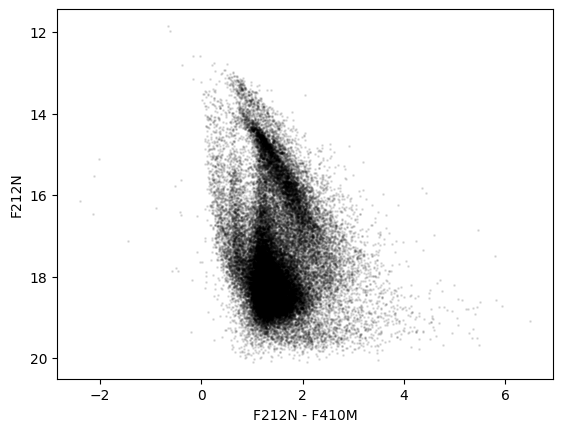

In [40]:
cat_use.plot_CMD('F212N', 'F410M', 'F212N', color='black', alpha=0.1, label='All', s=1)

In [44]:
b = np.linspace(14, 21, 50)
h_filament, b_filament = np.histogram(cat_filament.catalog['mag_ab_f410m'], bins=b)
h_cloudd, b_cloudd = np.histogram(cat_cloudd.catalog['mag_ab_f410m'], bins=b)
h_cloudc1, b_cloudc1 = np.histogram(cat_cloudc1.catalog['mag_ab_f410m'], bins=b)
h_cloudc2, b_cloudc2 = np.histogram(cat_cloudc2.catalog['mag_ab_f410m'], bins=b)
h_outside, b_outside = np.histogram(cat_outside.catalog['mag_ab_f410m'], bins=b)

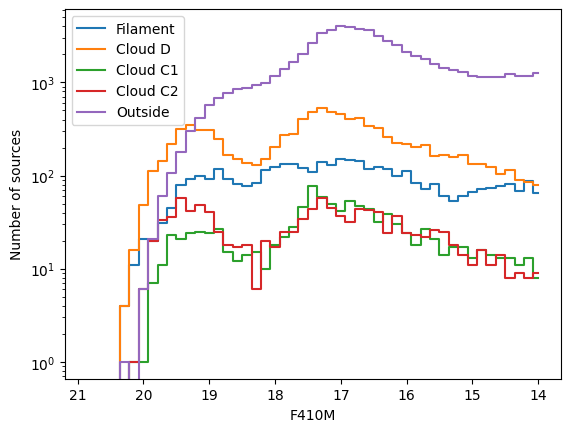

In [45]:
plt.step(b_filament[:-1], h_filament, label='Filament', where='mid')
plt.step(b_cloudd[:-1], h_cloudd, label='Cloud D', where='mid')
plt.step(b_cloudc1[:-1], h_cloudc1, label='Cloud C1', where='mid')
plt.step(b_cloudc2[:-1], h_cloudc2, label='Cloud C2', where='mid')
plt.step(b_outside[:-1], h_outside, label='Outside', where='mid')

plt.yscale('log')
plt.legend()
plt.xlabel('F410M')
plt.ylabel('Number of sources')
plt.gca().invert_xaxis()

In [46]:
b = np.linspace(14, 21, 50)
h_filament, b_filament = np.histogram(cat_filament.catalog['mag_ab_f212n'], bins=b)
h_cloudd, b_cloudd = np.histogram(cat_cloudd.catalog['mag_ab_f212n'], bins=b)
h_cloudc1, b_cloudc1 = np.histogram(cat_cloudc1.catalog['mag_ab_f212n'], bins=b)
h_cloudc2, b_cloudc2 = np.histogram(cat_cloudc2.catalog['mag_ab_f212n'], bins=b)
h_outside, b_outside = np.histogram(cat_outside.catalog['mag_ab_f212n'], bins=b)

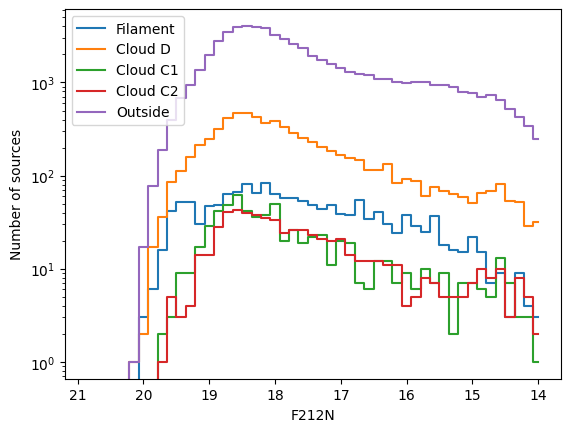

In [47]:
plt.step(b_filament[:-1], h_filament, label='Filament', where='mid')
plt.step(b_cloudd[:-1], h_cloudd, label='Cloud D', where='mid')
plt.step(b_cloudc1[:-1], h_cloudc1, label='Cloud C1', where='mid')
plt.step(b_cloudc2[:-1], h_cloudc2, label='Cloud C2', where='mid')
plt.step(b_outside[:-1], h_outside, label='Outside', where='mid')

plt.yscale('log')
plt.legend()
plt.xlabel('F212N')
plt.ylabel('Number of sources')
plt.gca().invert_xaxis()